In [ ]:
import numpy as np 
import pandas as pd 
import os
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

RangeIndex(start=0, stop=1490, step=1)


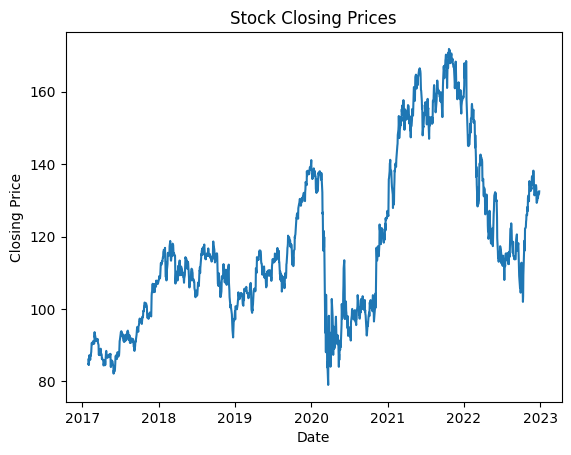

In [ ]:
df = pd.read_csv('JPM.csv')

# Convert the date column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

print( df.index )

# Set the date column as the index of the DataFrame
df.set_index('Date', inplace=True)

# Plot the closing price of the stock
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Closing Prices')
plt.show()

In [ ]:
print( df.index )

DatetimeIndex(['2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
               '2017-02-03', '2017-02-06', '2017-02-07', '2017-02-08',
               '2017-02-09', '2017-02-10',
               ...
               '2022-12-14', '2022-12-15', '2022-12-16', '2022-12-19',
               '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23',
               '2022-12-27', '2022-12-28'],
              dtype='datetime64[ns]', name='Date', length=1490, freq=None)


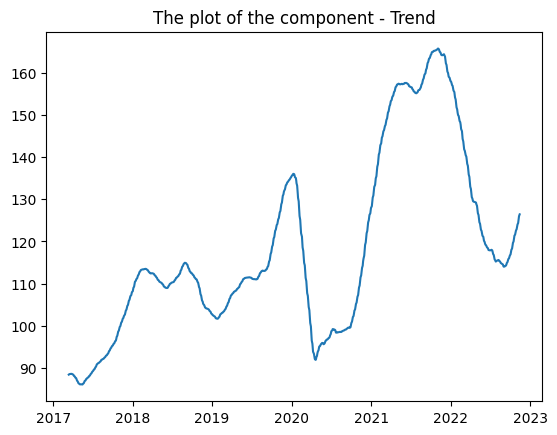

In [ ]:
# Use the seasonal_decompose function to decompose the time series
result_s = seasonal_decompose(df['Open'], model='additive', period = 60)

# Extracting the trend, seasonal, and residual components from the result
trend = result_s.trend
seasonal = result_s.seasonal
residual = result_s.resid


# Plotting the trend, seasonal, and residual components
plt.plot(trend, label='Trend')
plt.title('The plot of the component - Trend')
plt.show()

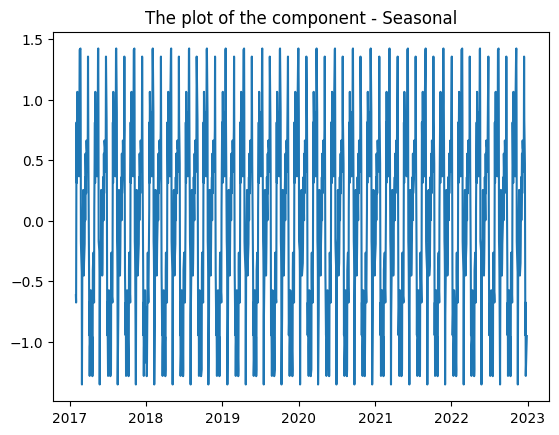

In [ ]:
plt.plot(seasonal, label = 'Seasonal')
plt.title('The plot of the component - Seasonal');

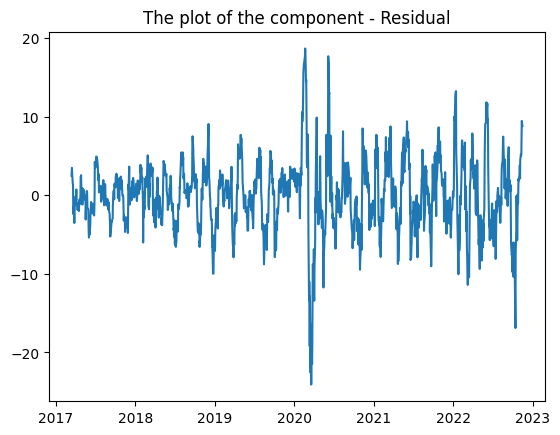

In [ ]:
plt.plot(residual, label='Residual')
plt.title('The plot of the component - Residual');

In [ ]:
from statsmodels.tsa.stattools import adfuller
    
adft1 = adfuller(df['Close'])    
output_adf = pd.Series(adft1[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
print(output_adf)

result = adfuller(df['Close'])
print(f'Augmented Dickey-Fuller Test: p-value = {result[1]}')
if result[1] < 0.05:
    print('So, time series is stationary')
else:
    print('So, time series is non-stationary')

Test Statistics                  -1.855184
p-value                           0.353429
No. of lags used                 13.000000
Number of observations used    1476.000000
dtype: float64
Augmented Dickey-Fuller Test: p-value = 0.3534286128335301
So, time series is non-stationary


In [ ]:
# Calculate the rolling mean and standard deviation - helps in smoothening of the curve
rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()


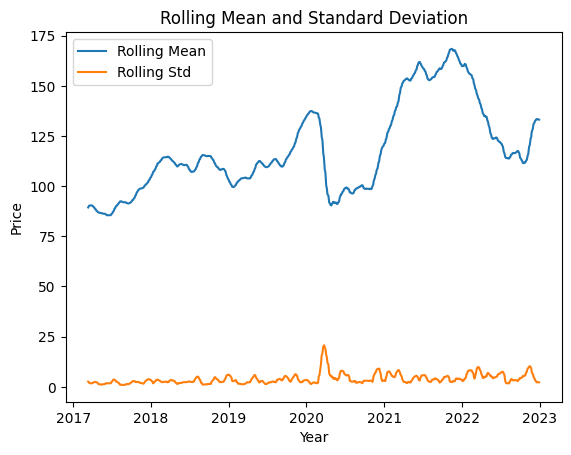

In [ ]:
# Plot the rolling mean and standard deviation
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

In [ ]:
# Calculate the returns of the stock using the close price
df['returns'] = df['Close'].pct_change()

# Calculate the moving average of the returns
df['ma'] = df['returns'].rolling(window=10).mean()

# Calculate the rolling mean and standard deviation of the returns
rolling_mean = df['returns'].rolling(window=10).mean()
rolling_std = df['returns'].rolling(window=10).std()

# Identify anomalies as data points that are more than 3 standard deviations from the mean
df['anomaly_finder'] = (df['returns'] - rolling_mean) > (3 * rolling_std)
df['anomaly_finder'].sum()



0

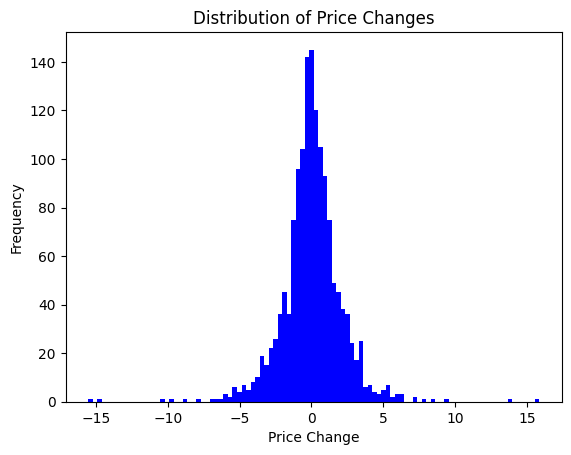

In [ ]:
# Calculate the difference between the current and previous closing price
df['Price Change'] = df['Close'].diff()

# Plot the distribution of price changes
plt.hist(df['Price Change'], bins=100, color='blue')
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Price Changes')
plt.show()

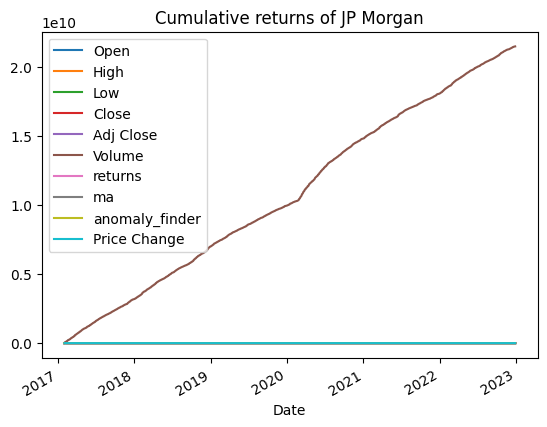

In [ ]:
dr = df.cumsum() #is used to determine the cumulative sum of the elements
dr.plot()
plt.title('Cumulative returns of JP Morgan');

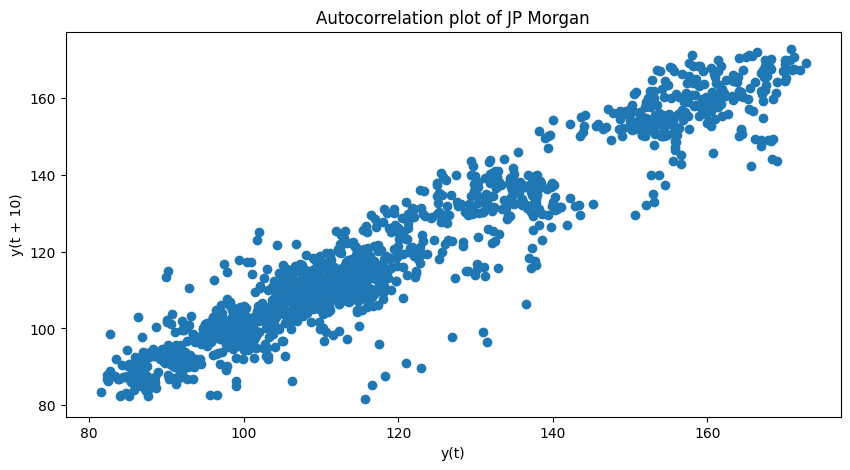

In [ ]:
plt.figure(figsize=(10,5))
lag_plot(df['Open'], lag=10)
plt.title('Autocorrelation plot of JP Morgan');

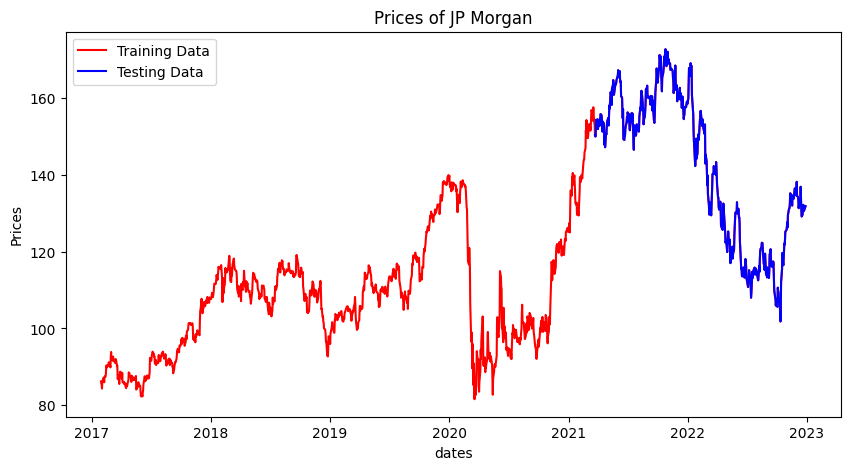

In [ ]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
plt.figure(figsize=(10,5))
plt.title('Prices of JP Morgan')
plt.xlabel('dates')
plt.ylabel('Prices')
plt.plot(df['Open'], 'red', label='Training Data')
plt.plot(test_data['Open'], 'blue', label='Testing Data')
#plt.xticks(np.arange(0,1600, 200), df.index[0:1600:200])
plt.legend()

In [ ]:
def smfn(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [ ]:
# Load the training and test data
train_ar = train_data['Open'].values
test_ar = test_data['Open'].values

history = [x for x in train_ar]
predictions = []

# Iterate over the test data and make predictions using the ARIMA model
for t in range(len(test_ar)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)

# Calculate the mean squared error and SMAPE
mse = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % mse)

smape = smfn(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % smape)


Testing Mean Squared Error: 5.353
Symmetric mean absolute percentage error: 1.271


In [ ]:
# Make forecasts for the next 15 days
forecasts = model_fit.forecast(steps=15)
print("The forecasts for the next 15 days are :",forecasts)

The forecasts for the next 15 days are : [131.55140869 131.57702839 131.57471504 131.57540049 131.57529491
 131.57531662 131.57531268 131.57531343 131.57531329 131.57531332
 131.57531331 131.57531331 131.57531331 131.57531331 131.57531331]


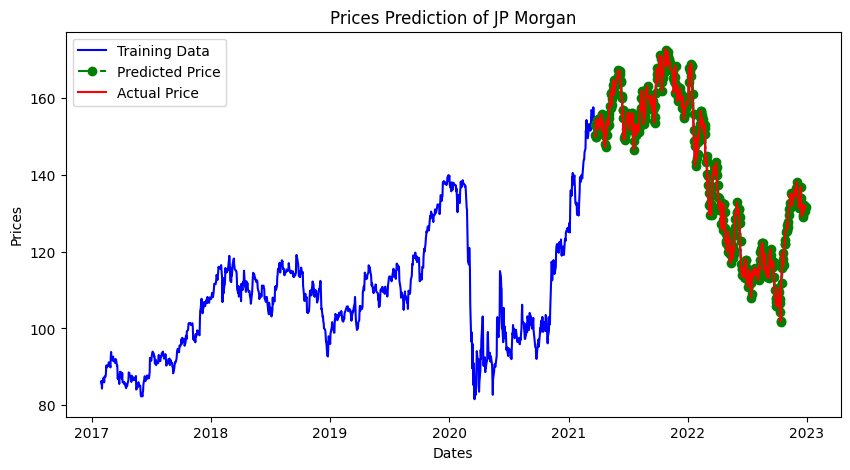

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['Open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashdot', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title('Prices Prediction of JP Morgan')
plt.xlabel('Dates')
plt.ylabel('Prices')
df_new = df.index
# plt.xticks(np.arange(0,2000, 200), df_new[0:2000:200])
plt.legend()

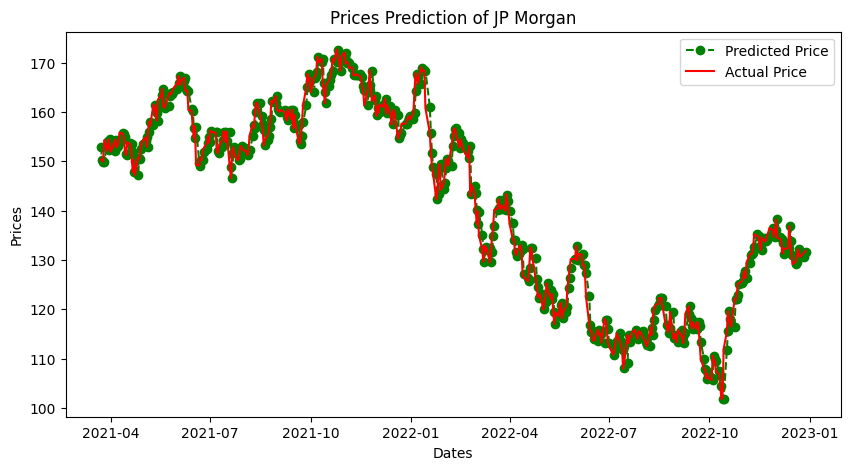

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
# plt.xticks(np.arange(1486,1856, 60), df['Date'][1486:1856:60])
plt.title('Prices Prediction of JP Morgan')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

In [ ]:
#Stock prediction of IBM:

In [ ]:
data = pd.read_csv('IBM.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,147.705551,148.001907,146.787766,147.466537,116.036713,4395815
1,2018-01-03,150.420654,152.782028,149.455063,151.520081,119.226349,9875914
2,2018-01-04,152.629059,155.181641,152.361374,154.588913,121.641075,7903785
3,2018-01-05,155.296371,155.736145,154.015289,155.344162,122.235374,5434807
4,2018-01-08,155.506699,156.701721,154.588913,156.281067,122.972595,5478425


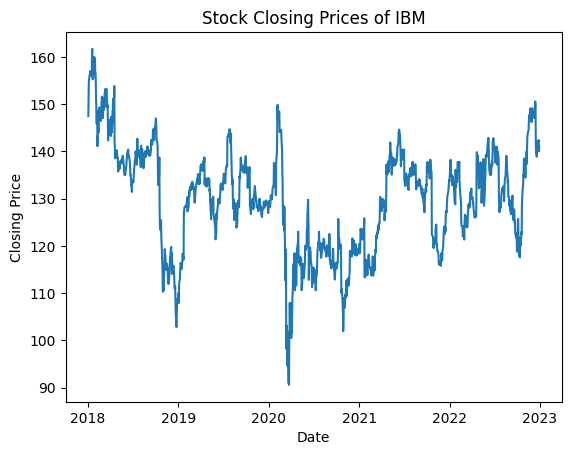

In [ ]:
# Convert the date column to a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Set the date column as the index of the DataFrame
data.set_index('Date', inplace=True)

# Plot the closing price of the stock
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Closing Prices of IBM')
plt.show()

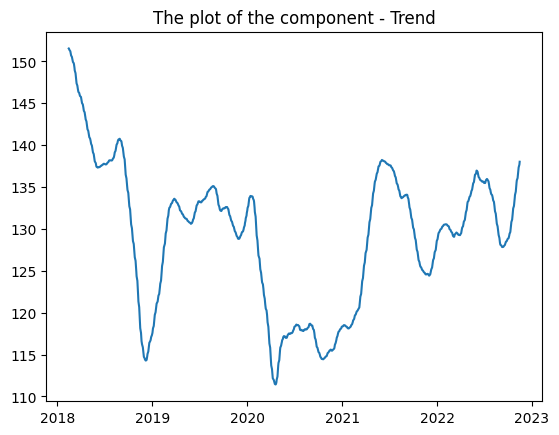

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Use the seasonal_decompose function to decompose the time series
result_s1 = seasonal_decompose(data['Open'], model='additive', period = 60)

# Extracting the trend, seasonal, and residual components from the result
trend = result_s1.trend
seasonal = result_s1.seasonal
residual = result_s1.resid

# Plotting the trend, seasonal, and residual components
plt.plot(trend, label='Trend')
plt.title('The plot of the component - Trend')
plt.show()

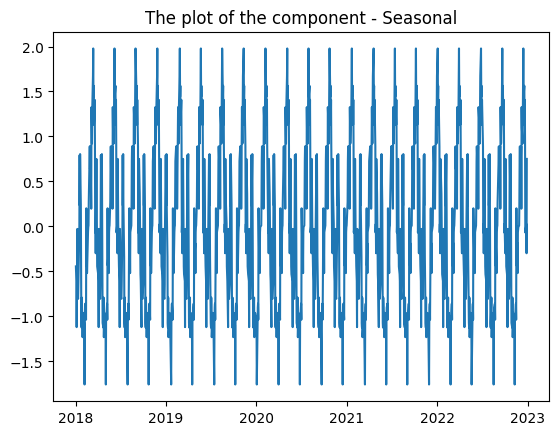

In [ ]:
plt.plot(seasonal, label = 'Seasonal')
plt.title('The plot of the component - Seasonal');

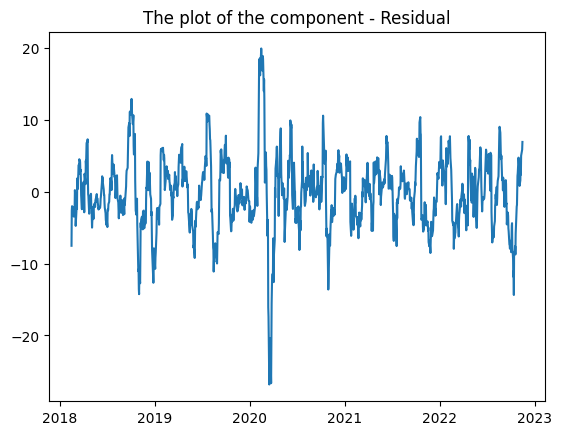

In [ ]:
plt.plot(residual, label='Residual')
plt.title('The plot of the component - Residual');

In [ ]:
from statsmodels.tsa.stattools import adfuller
    
adft2 = adfuller(data['Close'])    
output_adf1 = pd.Series(adft1[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
print(output_adf1)

result = adfuller(data['Close'])
print(f'Augmented Dickey-Fuller Test: p-value = {result[1]}')
if result[1] < 0.05:
    print('So, time series is stationary')
else:
    print('So, time series is non-stationary')

Test Statistics                  -1.855184
p-value                           0.353429
No. of lags used                 13.000000
Number of observations used    1476.000000
dtype: float64
Augmented Dickey-Fuller Test: p-value = 0.0006174445205201147
So, time series is stationary


In [ ]:
# Calculate the rolling mean and standard deviation - helps in smoothening of the curve
rolling_mean1 = data['Close'].rolling(window=30).mean()
rolling_std1 = data['Close'].rolling(window=30).std()

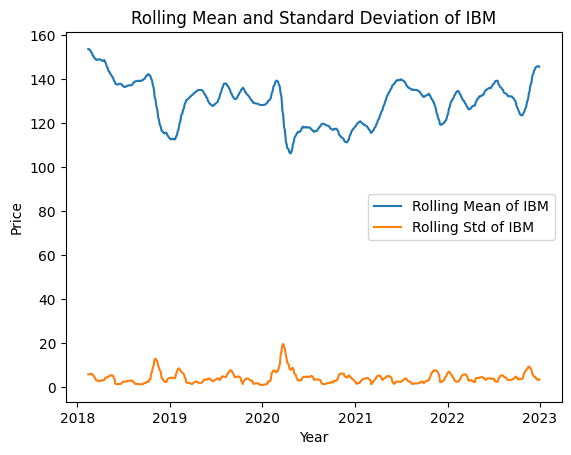

In [ ]:
# Plot the rolling mean and standard deviation
plt.plot(rolling_mean1, label='Rolling Mean of IBM')
plt.plot(rolling_std1, label='Rolling Std of IBM')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Rolling Mean and Standard Deviation of IBM')
plt.legend()
plt.show()

In [ ]:
# Calculate the returns of the stock using the close price
data['returns'] = data['Close'].pct_change()

# Calculate the moving average of the returns
data['ma'] = data['returns'].rolling(window=10).mean()

# Calculate the rolling mean and standard deviation of the returns
rolling_mean1 = data['returns'].rolling(window=10).mean()
rolling_std1 = data['returns'].rolling(window=10).std()

# Identify anomalies as data points that are more than 3 standard deviations from the mean
data['anomaly_finder'] = (data['returns'] - rolling_mean1) > (3 * rolling_std1)
data['anomaly_finder'].sum()


0

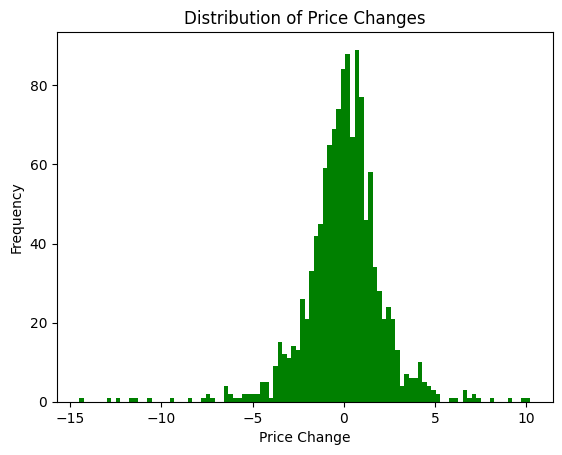

In [ ]:
# Calculate the difference between the current and previous closing price
data['Price Change'] = data['Close'].diff()

# Plot the distribution of price changes
plt.hist(data['Price Change'], bins=100, color='green')
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Price Changes')
plt.show()

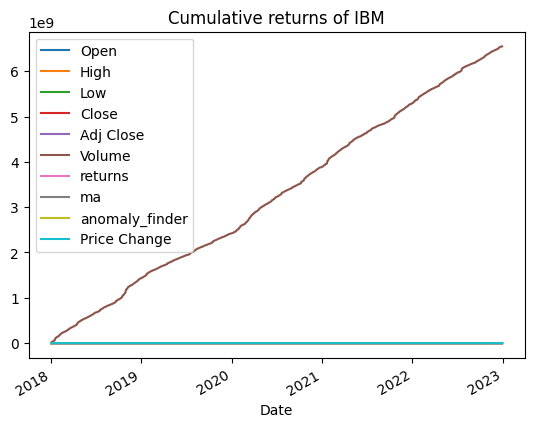

In [ ]:
dr1 = data.cumsum() #is used to determine the cumulative sum of the elements
dr1.plot()
plt.title('Cumulative returns of IBM');

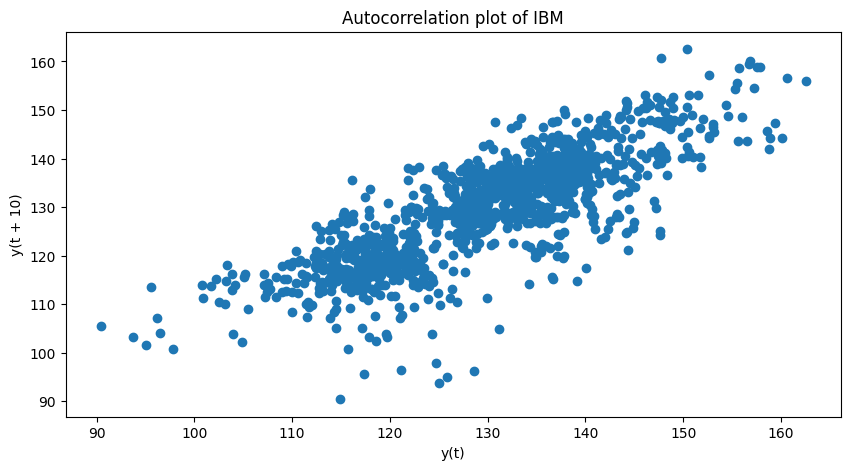

In [ ]:
plt.figure(figsize=(10,5))
lag_plot(data['Open'], lag=10)
plt.title('Autocorrelation plot of IBM');

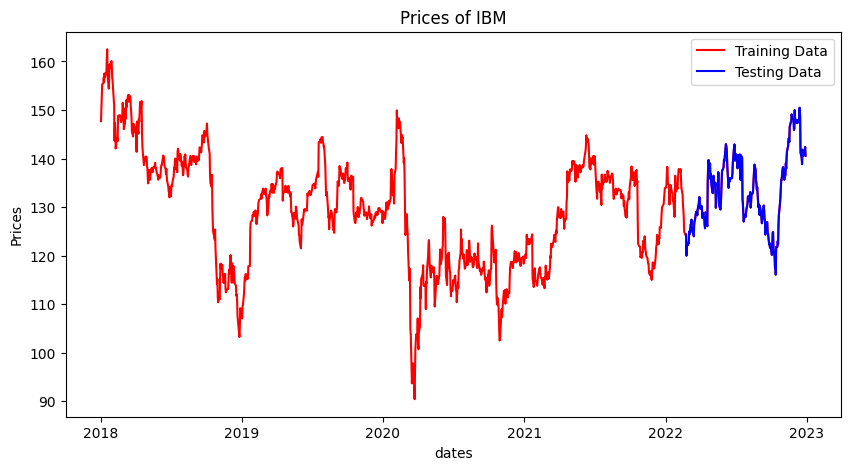

In [ ]:
train_datai, test_datai = data[0:int(len(df)*0.7)], data[int(len(df)*0.7):]
plt.figure(figsize=(10,5))
plt.title('Prices of IBM')
plt.xlabel('dates')
plt.ylabel('Prices')
plt.plot(data['Open'], 'red', label='Training Data')
plt.plot(test_datai['Open'], 'blue', label='Testing Data')
# plt.xticks(np.arange(0,2000, 200), data['Date'][0:2000:200])
plt.legend()

In [ ]:
def smfn1(y_true1, y_pred1):
    return np.mean((np.abs(y_pred1 - y_true1) * 200/ (np.abs(y_pred1) + np.abs(y_true1))))

In [ ]:
# Load the training and test data
train_ari = train_datai['Open'].values
test_ari = test_datai['Open'].values

historyi = [y for y in train_ari]
predictionsi = []

# Iterate over the test data and make predictions using the ARIMA model
for ti in range(len(test_ari)):
    modeli = ARIMA(historyi, order=(3,1,0))
    model_fiti = modeli.fit()
    outputi = model_fiti.forecast()
    yhati = outputi[0]
    predictionsi.append(yhati)
    obsi = test_ari[ti]
    historyi.append(obsi)

# Calculate the mean squared error and SMAPE
msei = mean_squared_error(test_ari, predictionsi)
print('Testing Mean Squared Error: %.3f' % msei)

smapei = smfn1(test_ari, predictionsi)
print('Symmetric mean absolute percentage error: %.3f' % smapei)

Testing Mean Squared Error: 4.045
Symmetric mean absolute percentage error: 1.096


In [ ]:
# Make forecasts for the next 15 days
forecasts1 = model_fiti.forecast(steps=15)
print("The forecasts for the next 15 days are :",forecasts1)

The forecasts for the next 15 days are : [142.45514999 142.49696444 142.50590546 142.50841616 142.50922849
 142.50943224 142.50949423 142.50951152 142.50951637 142.50951777
 142.50951816 142.50951827 142.50951831 142.50951832 142.50951832]
